# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [ ]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [57]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.debugger import Rule, rule_configs, ProfilerRule, DebuggerHookConfig, CollectionConfig, ProfilerConfig, FrameworkProfile
# from smdebug.trials import create_trial
# from smdebug.core.modes import ModeKeys

role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
print(f'Execition Role: {role}')
print(f'Default s3 bucket : {bucket}')

Execition Role: arn:aws:iam::884268130826:role/service-role/AmazonSageMaker-ExecutionRole-20241012T193078
Default s3 bucket : sagemaker-us-east-1-884268130826


In [58]:
bucket = "sagemaker-us-east-1-884268130826"

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip > /dev/null

In [ ]:
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix='imagesDogClassesSet')
print(f'Input path (S3 file path): {inputs}')

In [4]:
inputs="s3://sagemaker-us-east-1-884268130826/imagesDogClassesSet/"

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001, 0.1),
    'batch_size': CategoricalParameter([16 ,32, 64]),
    'epochs': IntegerParameter(2, 6)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [6]:
#TODO: Create estimators for your HPs

# TODO: Your estimator here
estimator = PyTorch(entry_point = 'hpo.py',
                    base_job_name = 'dog-classification--with-hpo',
                    role = role,
                    instance_count = 1,
                    instance_type = 'ml.m5.2xlarge', 
                    py_version = 'py36',
                    framework_version = '1.8')

# TODO: Your HP tuner here
tuner = HyperparameterTuner(estimator,
                         objective_metric_name,
                         hyperparameter_ranges,
                         metric_definitions,
                         max_jobs = 4,
                         max_parallel_jobs = 1,
                         objective_type = objective_type)



In [7]:
# TODO: Fit your HP Tuner
tuner.fit({'train': inputs}, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...................................................................................................................................................................................!


In [8]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-10-30 07:41:38 Starting - Found matching resource for reuse
2024-10-30 07:41:38 Downloading - Downloading the training image
2024-10-30 07:41:38 Training - Training image download completed. Training in progress.
2024-10-30 07:41:38 Uploading - Uploading generated training model
2024-10-30 07:41:38 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"32"',
 'epochs': '4',
 'lr': '0.014783257883991189',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-classification--with-hpo-2024-10-30-07-26-31-415"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-884268130826/dog-classification--with-hpo-2024-10-30-07-26-31-415/source/sourcedir.tar.gz"'}

In [9]:
#my best parameters
my_best_hyperparameters = {'batch_size': 32,
                        'epochs': 4,
                        'lr': 0.014783257883991189,}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [10]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, 
                                                       framework_profile_params = FrameworkProfile(num_steps=10))

collection_config = [CollectionConfig(name="CrossEntropyLoss_output_0", 
                                    parameters={"include_regex": "CrossEntropyLoss_output_0",
                                                            "train.save_interval": "10",
                                                            "eval.save_interval": "1"})]

debugger_config = DebuggerHookConfig(collection_configs = collection_config)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [11]:
# TODO: Create and fit an estimator

estimator = PyTorch(entry_point = 'train_model.py',
                    role = role,
                    instance_count=1,
                    instance_type = 'ml.m5.2xlarge',
                    py_version = 'py36',
                    framework_version = '1.6',
                    hyperparameters = my_best_hyperparameters,
                    profiler_config = profiler_config, 
                    debugger_hook_config = debugger_config, 
                    rules = rules ) # TODO: Your estimator here

estimator.fit({'train':inputs}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-10-30-07-47-07-314


2024-10-30 07:47:10 Starting - Starting the training job...
2024-10-30 07:47:35 Starting - Preparing the instances for trainingVanishingGradient: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-10-30 07:47:55 Downloading - Downloading input data...
2024-10-30 07:48:43 Downloading - Downloading the training image...
2024-10-30 07:49:14 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-10-30 07:49:17,297 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-10-30 07:49:17,299 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-30 07:49:17,310 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-10-30 07:49:17,312 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-10-30

In [12]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"This job's name: {job_name}")
print(f"This client's name: {client}")
print(f"The description: {description}")

This job's name: pytorch-training-2024-10-30-07-47-07-314
This client's name: <botocore.client.SageMaker object at 0x7f05e075eec0>
The description: {'TrainingJobName': 'pytorch-training-2024-10-30-07-47-07-314', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:884268130826:training-job/pytorch-training-2024-10-30-07-47-07-314', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-884268130826/pytorch-training-2024-10-30-07-47-07-314/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '32', 'epochs': '4', 'lr': '0.014783257883991189', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2024-10-30-07-47-07-314"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-884268130826/pytorch-training-2024-10-30-07-47-07-314/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884

In [13]:
# TODO: Plot a debugging output.
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print('Profiler report location: {}'.format(rule_output_path))

Profiler report location: s3://sagemaker-us-east-1-884268130826/pytorch-training-2024-10-30-07-47-07-314/rule-output


In [14]:
! aws s3 ls {rule_output_path} --recursive

2024-10-30 08:54:06     386993 pytorch-training-2024-10-30-07-47-07-314/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-10-30 08:54:05     237055 pytorch-training-2024-10-30-07-47-07-314/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-10-30 08:54:01        192 pytorch-training-2024-10-30-07-47-07-314/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-10-30 08:54:01        200 pytorch-training-2024-10-30-07-47-07-314/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-10-30 08:54:01       1928 pytorch-training-2024-10-30-07-47-07-314/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-10-30 08:54:01        127 pytorch-training-2024-10-30-07-47-07-314/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-10-30 08:54:01        199 pytorch-training-2024-10-30-07-47-07-314/rule-output/ProfilerReport/profiler-output/profiler-re

In [15]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-884268130826/pytorch-training-2024-10-30-07-47-07-314/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-884268130826/pytorch-training-2024-10-30-07-47-07-314/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-884268130826/pytorch-training-2024-10-30-07-47-07-314/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-884268130826/pytorch-training-2024-10-30-07-47-07-314/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json to ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json
download: s3://sagemaker-us-east-1-884268130826/pyto

In [17]:
import os

profiler_report_name = [ rule["RuleConfigurationName"]
                                            for rule in estimator.latest_training_job.rule_job_summary()
                                            if "Profiler" in rule["RuleConfigurationName"]
                                            ][0]

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [18]:
# TODO: Display the profiler output
import IPython

IPython.display.HTML(filename= profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [21]:
model_location = estimator.model_data
print(f"My model's location at: {model_location}")

My model's location at: s3://sagemaker-us-east-1-884268130826/pytorch-training-2024-10-30-07-47-07-314/output/model.tar.gz


In [59]:
model_location = "s3://sagemaker-us-east-1-884268130826/pytorch-training-2024-10-30-07-47-07-314/output/model.tar.gz"

In [60]:
jpeg_of_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_of_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_of_serializer,
            deserializer = json_of_deserializer
        )

In [62]:
# TODO: Deploy your model to an endpoint

pytorch_model = PyTorchModel(model_data = model_location,
                             role = role,
                             entry_point= "inference_my_deploy.py",
                             py_version = "py36",
                             framework_version = "1.8",
                             predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.m5.2xlarge") # TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-884268130826/pytorch-training-2024-10-30-07-47-07-314/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-884268130826/pytorch-inference-2024-10-30-14-04-58-608/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-10-30-14-05-07-112
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-10-30-14-05-07-837
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-10-30-14-05-07-837


--------!

[42]


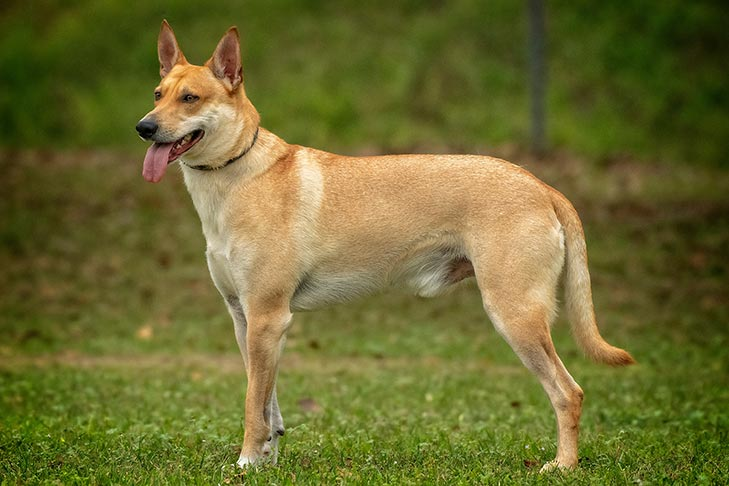

In [63]:
import requests
from PIL import Image
import io
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
image_url = "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg"
request_dict={"url": image_url}

img_bytes = requests.get(request_dict['url']).content
response = predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
label_predicted = np.argmax(response, 1)
print(label_predicted)

Image.open(io.BytesIO(img_bytes))

In [76]:
def display_prediction(url):
    request_dict={ "url": url }
    image_bytes = requests.get(request_dict['url']).content
    response=predictor.predict(image_bytes, initial_args={"ContentType": "image/jpeg"})
    display(Image.open(io.BytesIO(image_bytes)))
    label_predictedlabel_predicted = np.argmax(response, 1)
    print(f"Index: {label_predicted}")

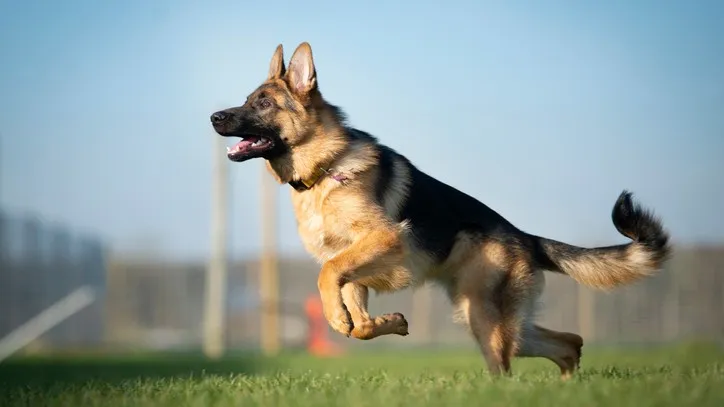

Index: [70]


In [77]:
display_prediction("https://cdn.mos.cms.futurecdn.net/Tdom4TwTjsVFLhXrNqnZHS-970-80.jpg.webp")

In [56]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-10-30-09-51-07-592
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-10-30-09-51-07-592
